In [5]:
from disqco.circuits.cp_fraction import cp_fraction
from disqco.graphs.QC_hypergraph import QuantumCircuitHyperGraph
from qiskit import transpile
from qiskit.circuit.library import QFT, QuantumVolume  
from disqco.graphs.quantum_network import QuantumNetwork, linear_coupling, grid_coupling, random_coupling, all_to_all
from disqco.parti.FM.fiduccia import FiducciaMattheyses
from disqco.graphs.coarsening.coarsener import HypergraphCoarsener
import numpy as np

# Circuit setup
num_qubits = 64
circuit = cp_fraction(num_qubits=num_qubits, depth=num_qubits, fraction=0.5)
circuit = transpile(circuit, basis_gates=['cp', 'u'])

# Partition setup
num_partitions = 16
qpu_sizes = [int(num_qubits/num_partitions)+1] * num_partitions


graph = QuantumCircuitHyperGraph(circuit)

print(f"Circuit: {num_qubits} qubits, depth {circuit.depth()}")
print(f"Partitions: {num_partitions} QPUs, sizes: {qpu_sizes}")
print(f"Hypergraph: {len(graph.nodes)} nodes, {len(graph.hyperedges)} edges")

 

Circuit: 64 qubits, depth 64
Partitions: 16 QPUs, sizes: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Hypergraph: 4096 nodes, 4476 edges


In [6]:
# Create different network topologies
topologies = {
    'All-to-All': all_to_all(num_partitions),
    'Linear': linear_coupling(num_partitions),
    'Grid': grid_coupling(num_partitions),
    'Random': random_coupling(num_partitions, p=0.4)
}

networks = {}
for name, coupling in topologies.items():
    networks[name] = QuantumNetwork(qpu_sizes, coupling)
    print(f"\n{name} Network:")
    print(f"  Nodes: {list(networks[name].qpu_graph.nodes())}")
    print(f"  Edges: {list(networks[name].qpu_graph.edges())}")


All-to-All Network:
  Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  Edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (10, 

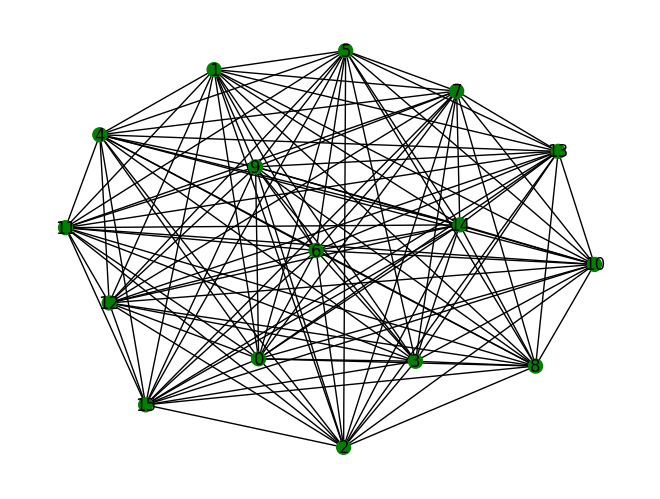

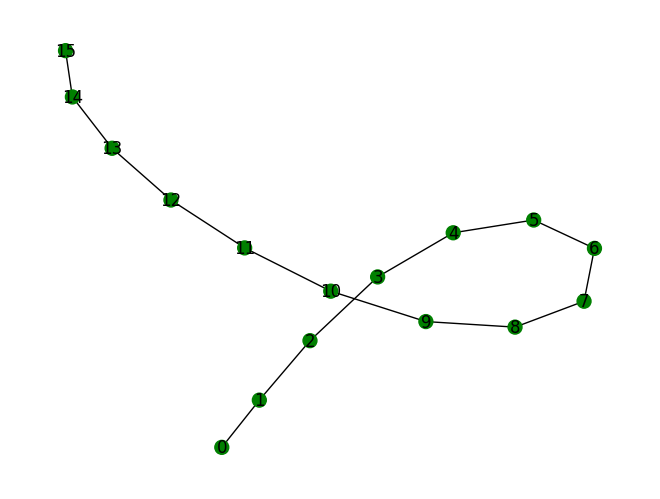

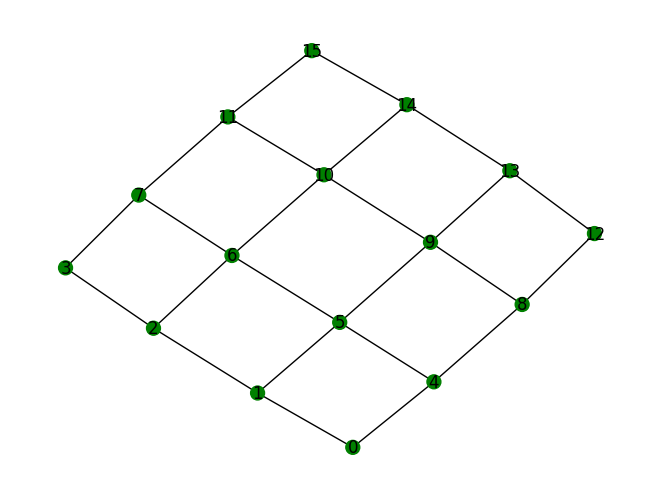

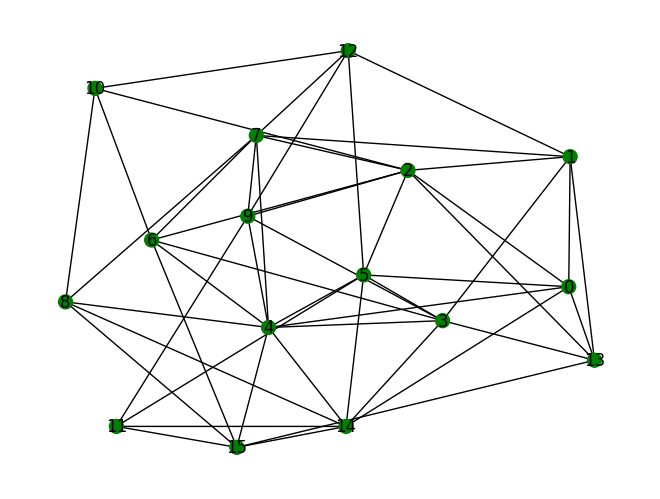

<Figure size 640x480 with 0 Axes>

In [7]:
# Visualize each network topology
import matplotlib.pyplot as plt



for i, (name, network) in enumerate(networks.items()):

    network.draw()


plt.tight_layout()
plt.show()


In [8]:
# Run multilevel partitioning for each network topology
coarsener = HypergraphCoarsener()
results = {}

for name, network in networks.items():
    print(f"\n{'='*50}")
    print(f"Running multilevel partitioning for {name} network")
    print(f"{'='*50}")
    
    # Initialize partitioner
    partitioner = FiducciaMattheyses(
        circuit=circuit,
        hypergraph=graph,
        network=network
    )
    
    # Run multilevel partitioning
    result = partitioner.multilevel_partition(
        coarsener=coarsener.coarsen_recursive_batches_mapped,
    )
    
    results[name] = result
    print(f"Final cost for {name}: {result['best_cost']}")


Running multilevel partitioning for All-to-All network
Final cost for All-to-All: 655

Running multilevel partitioning for Linear network
Final cost for Linear: 2019

Running multilevel partitioning for Grid network
Final cost for Grid: 1129

Running multilevel partitioning for Random network
Final cost for Random: 831


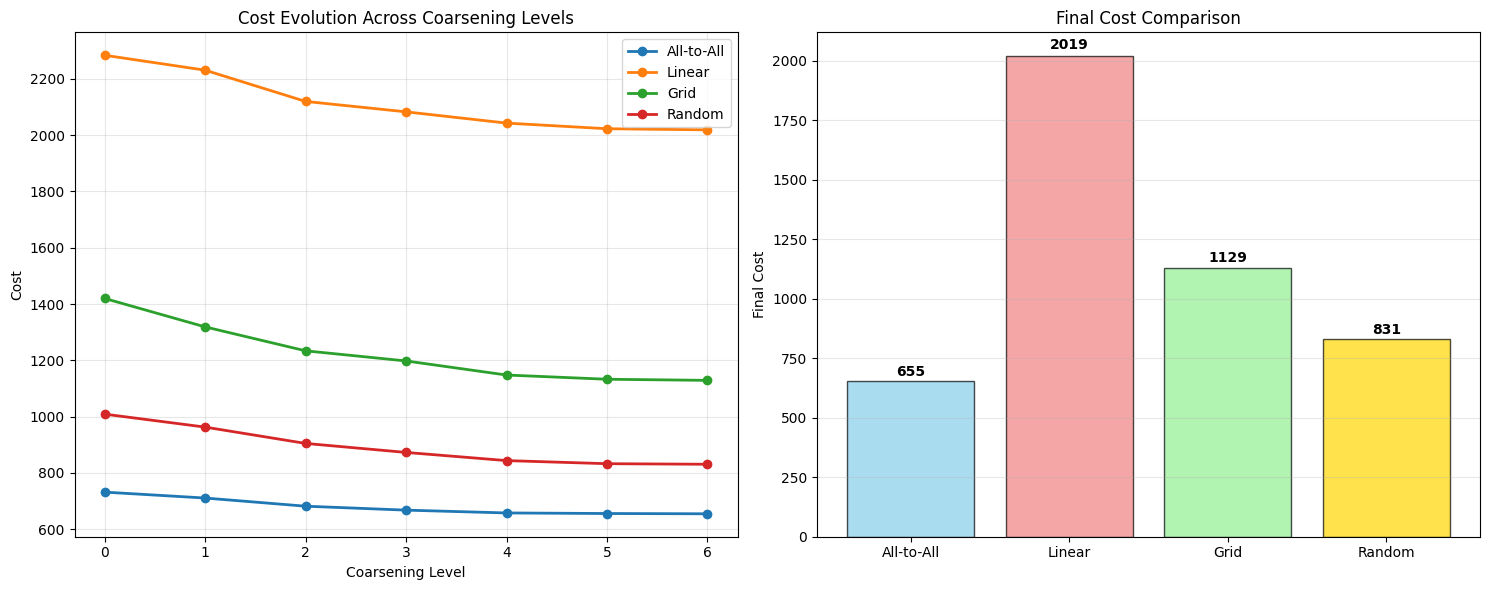

In [9]:
# Visualize cost evolution for each topology
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Cost evolution per level
for name, result in results.items():
    cost_list = result['cost_list']
    ax1.plot(range(len(cost_list)), cost_list, 'o-', label=name, linewidth=2, markersize=6)

ax1.set_xlabel('Coarsening Level')
ax1.set_ylabel('Cost')
ax1.set_title('Cost Evolution Across Coarsening Levels')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Final cost comparison
topologies_names = list(results.keys())
final_costs = [results[name]['best_cost'] for name in topologies_names]
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

bars = ax2.bar(topologies_names, final_costs, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Final Cost')
ax2.set_title('Final Cost Comparison')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, cost in zip(bars, final_costs):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{cost}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()